## Imports 

In [328]:
import numpy as np
import pandas as pd

# Import the Generator class
from bioverse.generator import Generator
from bioverse.constants import ROOT_DIR
from bioverse.custom import label_lateM
from bioverse import util

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 20.

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 200
pd.options.display.max_columns = 80

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define some parameters

In [329]:
# randomState = 42
# np.random.seed(randomState)
Mst_threshold = 0.4    # stellar mass threshold (i.e., 'what do we call "late"?')
d_max = 100            # max. distance to stars in parsec

## Generate stars

In [330]:
# Open the transit mode generator and display its properties
# generator = Generator('transit')

g_transit = Generator(label=None)
g_transit.insert_step('create_stars_Gaia')

# Make sure there are some hotter stars as well 
# (is this a bug in Bioverse that there are no hotter planets than T_eff_split?)
g_transit.set_arg('T_eff_split', 9700)

# Insert a function to the generator that labels late M dwarfs, defining a stellar mass threshold Mst_threshold.
g_transit.insert_step(label_lateM)

stars = g_transit.generate(d_max=d_max, Mst_threshold=Mst_threshold)
stars.to_pandas()

Created a new Generator


,d,ra,dec,T_eff_st,M_G,M_st,simulated,R_st,L_st,SpT,subSpT,age,starID,is_late
0,94.833395,106.065838,-52.309343,5146.098200,5.677804,0.826098,True,0.810016,0.413303,K,K1.5V,4.513248,0,False
1,93.869882,234.691824,-8.674328,2275.926910,16.348888,0.077370,True,0.106518,0.000274,L,L0V,5.047672,1,True
2,96.954317,44.974913,-27.617093,3523.895239,9.536629,0.419116,True,0.412594,0.023771,M,M2.5V,6.589724,2,False
3,97.616319,274.861114,-40.192982,3137.065417,11.786488,0.194826,True,0.248560,0.005421,M,M4.5V,5.521769,3,True
4,78.107819,193.137192,-56.122247,3599.245195,9.251962,0.454774,True,0.446804,0.030347,M,M2V,7.343600,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489670,78.225462,331.040268,-64.482191,2252.975601,16.358725,0.077043,True,0.107830,0.000270,L,L0V,4.607244,489670,True
489671,91.241729,218.272932,-54.224957,3066.193449,12.280793,0.170341,True,0.221750,0.003991,M,M5V,5.009255,489671,True
489672,94.119974,1.623663,-28.398165,2957.471647,13.777852,0.114330,True,0.142763,0.001433,M,M6V,7.473918,489672,True
489673,63.945723,281.413608,-45.681028,2915.130498,14.054481,0.108684,True,0.136552,0.001245,M,M6V,5.329604,489673,True


## Generate planets 

Following cell must be run _once_ after previous one:

In [331]:
g_transit.insert_step('create_planets_SAG13')
g_transit.insert_step('assign_orbital_elements')
g_transit.insert_step('impact_parameter')
g_transit.insert_step('assign_mass')
g_transit.insert_step('compute_transit_params')



# Make sure occurrence rate is modulated with M_star
g_transit.set_arg('normalize_SpT', True)
# g_transit.set_arg('normalize_SpT', False)

# show generator steps
g_transit

# Show parameters of the 'create_planets_SAG13' step
# g_transit.steps[0]

# Simulate only transiting planets:
g_transit.set_arg('transit_mode', True)
# g_transit.get_arg('transit_mode')

### Run the Generator

Now, let's use this Generator object to produce an ensemble of transiting planets within 100 parsecs.

In [332]:
sample = g_transit.generate(d_max=d_max, Mst_threshold=Mst_threshold, optimistic=True)
# print("Generated a sample of {:d} planets including {:d} exo-Earth candidates.".format(len(sample), sample['EEC'].sum()))
len(sample)

18585

Let's plot the planets around late M dwarfs and earlier stars:

total number of planets:
 $N_{late} = 15853$
 $N_{early} = 2732


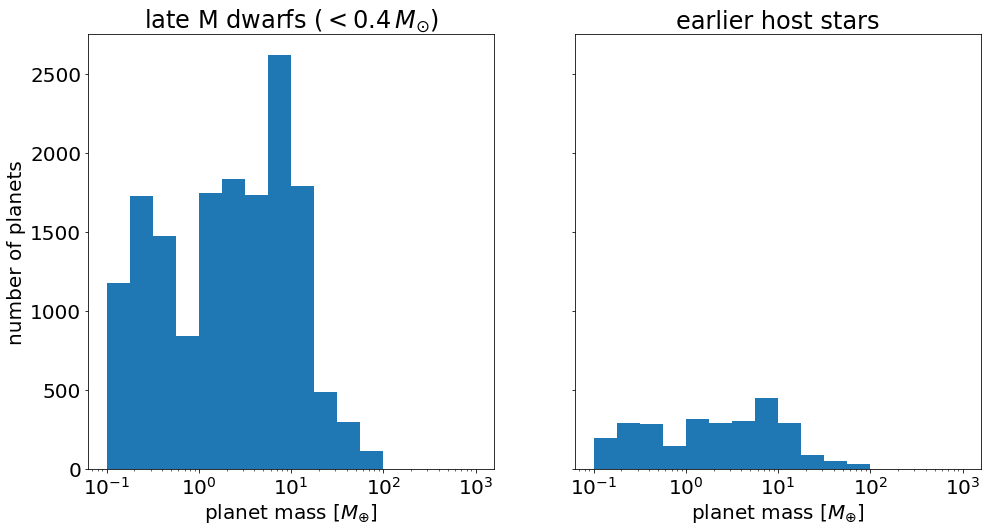

In [333]:
bins = util.compute_logbins(binWidth_dex=0.25, Range=(0.1, 1000.))

fig, axs = plt.subplots(ncols=2, figsize=(16,8), sharey=True)
late = sample['is_late']
early = ~sample['is_late']

# planets around late M dwarfs
axs[0].hist(sample[late]['M'], bins=bins)
axs[0].set_title('late M dwarfs ($<{:.1f}\, M_{{\odot}}$)'.format(Mst_threshold))
axs[0].set_ylabel('number of planets')

# planets around other stars 
axs[1].hist(sample[early]['M'], bins=bins)
axs[1].set_title('earlier host stars')

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlabel('planet mass [$M_{{\oplus}}$]')
    
print('total number of planets:\n $N_{{late}} = {}$\n $N_{{early}} = {}'.format(len(sample[late]), len(sample[early])))


In [334]:
occ_late = len(sample[late])/len(stars[stars['is_late']])
occ_early = len(sample[late])/len(stars[~stars['is_late']])

print('detection rate of planets (aka transiting planets per star in the sample):\n $n_{{late}} = {:.3f}$\n $n_{{early}} = {:.3f}'.format(occ_late, occ_early))


detection rate of planets (aka transiting planets per star in the sample):
 $n_{late} = 0.045$
 $n_{early} = 0.115


Of course, you may wish to change the `oceans` function later, and it would be tiring to add it to the Generator again each time. Instead, we can point the Generator to a Python file containing your function, which must be saved under ``bioverse/functions/``.

In [68]:
# Reload the generator to erase the previously-added step
generator = Generator('transit')

# Write the function definition as a string
func = """
# Define a function that accepts and returns a Table object
def oceans(d, f_ocean_min=0, f_ocean_max=1):
    # First, assign zero for all planets
    d['f_ocean'] = np.zeros(len(d))

    # Next, assign a random non-zero value for exo-Earth candidates
    EEC = d['EEC']
    d['f_ocean'][EEC] = np.random.uniform(f_ocean_min, f_ocean_max, size=EEC.sum())

    # Finally, return the Table with its new column
    return d
"""

# Save the function to a .py file
with open(ROOT_DIR+'/example_oceans.py', 'w') as f:
    f.write(func)

# Insert this function into the Generator and specify the filename
generator.insert_step('oceans', filename='example_oceans.py')

# Verify that the new step has been added
generator

Generator with 13 steps:
 0: Function 'create_stars_Gaia' with 6 keyword arguments.
 1: Function 'create_planets_SAG13' with 9 keyword arguments.
 2: Function 'assign_orbital_elements' with 1 keyword arguments.
 3: Function 'geometric_albedo' with 2 keyword arguments.
 4: Function 'impact_parameter' with 1 keyword arguments.
 5: Function 'assign_mass' with no keyword arguments.
 6: Function 'compute_habitable_zone_boundaries' with no keyword arguments.
 7: Function 'compute_transit_params' with no keyword arguments.
 8: Function 'classify_planets' with no keyword arguments.
 9: Function 'scale_height' with no keyword arguments.
10: Function 'Example1_water' with 3 keyword arguments.
11: Function 'Example2_oxygen' with 2 keyword arguments.
12: Function 'oceans' with 2 keyword arguments.

Now, any changes you make to the `oceans` function under `example_oceans.py` will automatically be applied. Finally, you will want to save this Generator under a new name, so that you don't have to re-add the new step every time you load Bioverse:

In [47]:
# Save the new Generator
generator.save('transit_oceans')

# Reload it
generator = Generator('transit_oceans')

The following lines of code will clean up the files created during this exercise:

In [48]:
import os
trash = [ROOT_DIR+'/Objects/Generators/transit_oceans.pkl', ROOT_DIR+'/example_oceans.py']
for filename in trash:
    if os.path.exists(filename):
        os.remove(filename)

The next example will translate this simulated sample of planetary systems into a dataset from a transit spectroscopy survey.